# Vignette deepLIFT region (Fig 5c) with CENTIPEDE TFBS

1. Generate deepLIFT scores for validation set
2. Choose a vignette which seems to have motif sets
3. Create a smooth signal plot
4. Annotate w/ CENTIPEDE binding sites in Illustrator, slap a P-value by comparing scores at TFBS to entire region (Mann-Whitney U)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
reload(deeplift)
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:03:00.0)


In [3]:
modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

import momma_dragonn
# load the validation set
valid_path = "../hdf5files/sharpr_znormed_jul23/valid_data.hdf5"
data = (momma_dragonn.data_loaders.hdf5_data_loader
              .MultimodalAtOnceDataLoader(path_to_hdf5=valid_path,
                                          strip_enclosing_dictionary=True)
              .get_data())

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

preds = deeplift_prediction_function([data.X], batch_size = 500)

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

import sys

letter_list = ['A', 'C', 'G', 'T']

def convert_one_hot_seq_to_acgt(one_hot_seq):
    seq = ''
    for i in range(len(one_hot_seq)):
        seq += letter_list[np.argmax(one_hot_seq[i])]
    return seq

import time
t0 = time.time()
input_data_sequences = []
print_interval = int(1e4)
for (i, seq) in enumerate(np.array(data.X)):
    if i % print_interval == 0 and i > 0:
        print ("Converting sequences " + str(i - print_interval) +
               " to " + str(i) + " from one-hot to ACGT strings took " +
               str(round(time.time() - t0, 3)) + "s.")
        t0 = time.time()
    char_seq = convert_one_hot_seq_to_acgt(seq)
    input_data_sequences.append(char_seq)
    
input_data_sequences = np.array(input_data_sequences)

import avutils
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [2, 5, 8, 11] # 'average' tasks for k5minp, k5sv40, hepminp, hepsv40 respectively

task_to_deeplift_multipliers = OrderedDict()
task_to_deepliftgcref_multipliers = OrderedDict()
task_to_gradinput_multipliers = OrderedDict()
task_to_guidedbackprop_multipliers = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_multipliers[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=8,
                                                      batch_size=500,
                                                      progress_update=100000))
    
task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_idxs:
    summed_scores = np.sum(task_to_deeplift_multipliers[task_idx], axis=2)
    task_to_deeplift_summedscores[task_idx] = np.expand_dims(summed_scores, axis=2)*data.X

Using Theano backend.


False
Input modes [u'sequence']
Output modes [u'output']
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 5 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Converting sequences 0 to 10000 from one-hot to ACGT strings took 2.167s.
100000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 100000
100000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 100000
100000 reference seqs generated
One hot encoding sequences...
One hot encoding done.

In [4]:
task_to_deeplift_seqcontribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_seqcontribs[task_idx] = task_to_deeplift_multipliers[task_idx]*data.X

In [83]:
import glob
import os, sys
import h5py

import numpy as np
from scipy.signal import correlate2d
import pandas as pd

class PWM(object):
    def __init__(self, weights, name=None, threshold=None):
        self.weights = weights
        self.name = name
        self.threshold = threshold

    @staticmethod
    def from_homer_motif(motif_file):
        with open(motif_file) as fp:
            header = fp.readline().strip().split('\t')
            name = header[1]
            threshold = float(header[2])
            weights = np.loadtxt(fp)

        return PWM(weights, name, threshold)

def load_all_pwms():
    homer_path = '../../data/motifs/homer/*.motif'
    homer_pwms = [PWM.from_homer_motif(motif_file)
            for motif_file in glob.glob(homer_path)]

#     encode_motifs = '../../data/motifs/encode/motifs.txt'
#     encode_pwms = PWM.get_encode_pwms(encode_motifs)
# 
#     cisbp_motifs_path = '../../data/motifs/cisbp/*.txt'
#     cisbp_annots = pd.read_table("../../data/motifs/cisbp/annots/cisbp_TF_ids.txt")
#     cisbp_pwms = [PWM.from_cisbp_motif(motif_file) 
#                   for motif_file in glob.glob(cisbp_motifs_path)]

#     id_list = cisbp_annots.ix[:,"Motif_ID"].tolist()
#     for pwm in cisbp_pwms:
#         if pwm.name.split('.txt')[0] in id_list:
#             ind = id_list.index(pwm.name.split('.txt')[0])
#             pwm.name = cisbp_annots.ix[ind,"TF_Name"]
#     return (homer_pwms, encode_pwms, cisbp_pwms)
    return homer_pwms

# Get the maximal and minimal cross correlation between PWM and Filter
# Notes: can play with fillvalue of 0 or 0.25
def max_min_cross_corr(pwm, conv_filter):
    if conv_filter.shape[1] != 4:
        conv_filter = conv_filter.T
    assert conv_filter.shape[1] == 4
    assert pwm.shape[1] == 4
    
    corr = correlate2d(pwm, conv_filter, mode='same', fillvalue=0.)
    # we are only interested in the part where the 'letter' axes are aligned,
    # and the correlation is over the position axis only, which is in the 2nd
    # column
    allowed_corr = corr[:, 1]
    max_corr = np.max(allowed_corr)
    min_corr = np.min(allowed_corr)

    # max_pos (and min_pos) relates to the alignment between the pwm and the
    # conv_filter as follows - more generally,
    #
    # Position floor(w / 2) - i maps to position 0 on the (padded) PWM
    #
    # where w = width of conv filter, and i is the position given by best_pos
    # (or more generally, the index into allowed_corr). If a negative position
    # is obtained, that means that position 0 on the conv_filter maps to a
    # later position on the PWM.
    max_pos = np.argmax(allowed_corr)
    min_pos = np.argmin(allowed_corr)

    return ((max_corr, max_pos), (min_corr, min_pos))

# Use to get PWM matches for a given filter 
# Normalize filter by max/min activation
def get_pwm_matches_for_filter(conv_filter, pwms, topk=3, bottomk=3):

    min_activation = conv_filter.min(axis=0).sum()
    max_activation = conv_filter.max(axis=0).sum()
    activation_range = max_activation - min_activation

    def norm_cc(cc):
        return (cc - min_activation) / activation_range

    hits = []

    for idx, pwm in enumerate(pwms):
        (max_cc, max_pos), (min_cc, min_pos) = \
            max_min_cross_corr(pwm.weights, conv_filter)
        (max_cc_rc, max_pos_rc), (min_cc_rc, min_pos_rc) = \
            max_min_cross_corr(pwm.weights, conv_filter[::-1,::-1])

        if max_cc_rc > max_cc:
            hits.append((norm_cc(max_cc_rc), max_pos_rc, idx, pwm.name))
        else:
            hits.append((norm_cc(max_cc), max_pos, idx, pwm.name))
        if bottomk != None:
            hits.append((norm_cc(min_cc), min_pos, idx, pwm.name))

        hits.sort(reverse=True)

    if bottomk == None:
        return hits[:topk]
    else:
        return hits[:topk] + hits[-bottomk:]
    
homer_pwms = load_all_pwms()

print get_pwm_matches_for_filter(conv_filter = task_to_deeplift_seqcontribs[2][3403], 
                                 pwms = homer_pwms, 
                                 topk = 3, 
                                 bottomk = 3)

print homer_pwms[329]

62
Sequence index 17183
Sequence: Huvec_1_146_16_chr8_37620075_n
Start coordinate: 37620008
True value: 3.101
Predicted value: 1.593


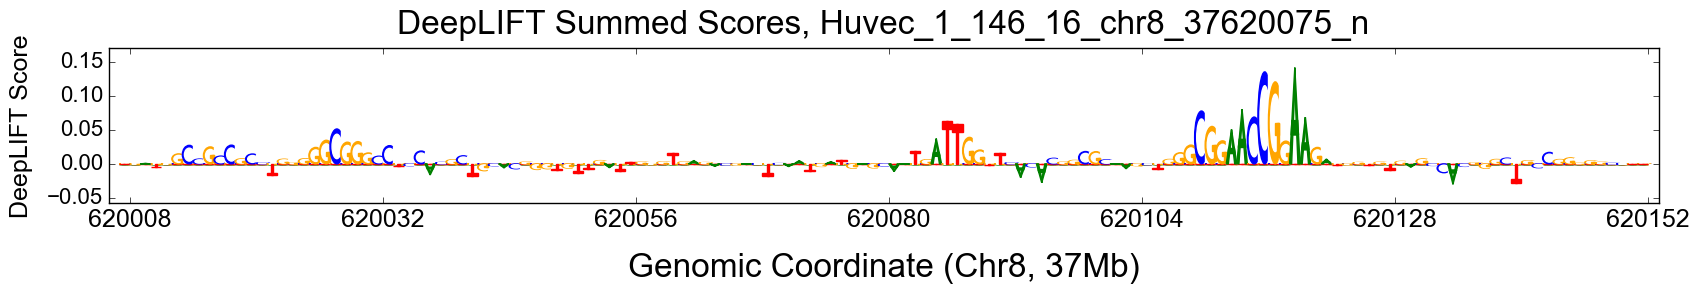

In [5]:
import gzip

valFragmentNames = [s.strip() for s in gzip.open('../splits/sharpr_znormed_jul23/val_split.txt.gz').readlines()]

task_idx = 2
preds = np.array(preds)
ordered_idxs = np.argsort(data.Y[:, task_idx])[::-1]
# print np.array(data.Y)[ordered_idxs[:10]]
pred_margin = 0.5 # maximum fraction that the prediction can differ by

num_test = 1000
idxs_to_check = []
checked_regions = []
for i in range(0,0+num_test):
    y_true_idx = data.Y[ordered_idxs[i]][task_idx]
    y_pred_idx = preds[ordered_idxs[i]][task_idx]
    if abs(abs(y_pred_idx - y_true_idx) / y_true_idx) > pred_margin:
        continue
    else:
        name = valFragmentNames[ordered_idxs[i]]
        cell = name.split('_')[0]
        region = '_'.join(name.split('_')[:3])
#         if cell == 'K562':
        if True:
            if region not in checked_regions:
                idxs_to_check.append(ordered_idxs[i])
                checked_regions.append(region)

# idxs_to_check = ordered_idxs[5:15]
        
print(len(idxs_to_check))

# np.random.shuffle(idxs_to_check)
idxs_to_check = idxs_to_check[:1]

# np.random.shuffle(idxs_to_check)
        
for idx in idxs_to_check:
    name = valFragmentNames[idx]
    print("Sequence index %d" % idx)
    print("Sequence: %s" % name)
    start_coord = int(name.split('_')[-2]) - 147 + int(name.split('_')[3])*5
    print "Start coordinate: %d" % start_coord
    print("True value: %.3f" % data.Y[idx][task_idx])
    print("Predicted value: %.3f" % preds[idx][task_idx])
    mb = start_coord / 1000000
    start_coord %= 1000000
    viz_sequence.plot_weights(task_to_deeplift_summedscores[task_idx][idx],
                              tickcount = 6,
                              figsize = (20, 2),
                              xlabel = 'Genomic Coordinate (Chr8, %dMb)' % mb,
                              start_coord = start_coord,
                              xtickfontsize = 18,
                              title = 'DeepLIFT Summed Scores, %s' % name
                             )
#     viz_sequence.plot_weights(task_to_deeplift_seqcontribs[task_idx][idx],
#                               tickcount = 6,
#                               figsize = (20, 2),
#                               xlabel = 'Genomic Coordinate (Chr8, %dMb)' % mb,
#                               start_coord = start_coord,
#                               xtickfontsize = 18,
#                               title = 'DeepLIFT Summed Scores, %s' % name
#                              )

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


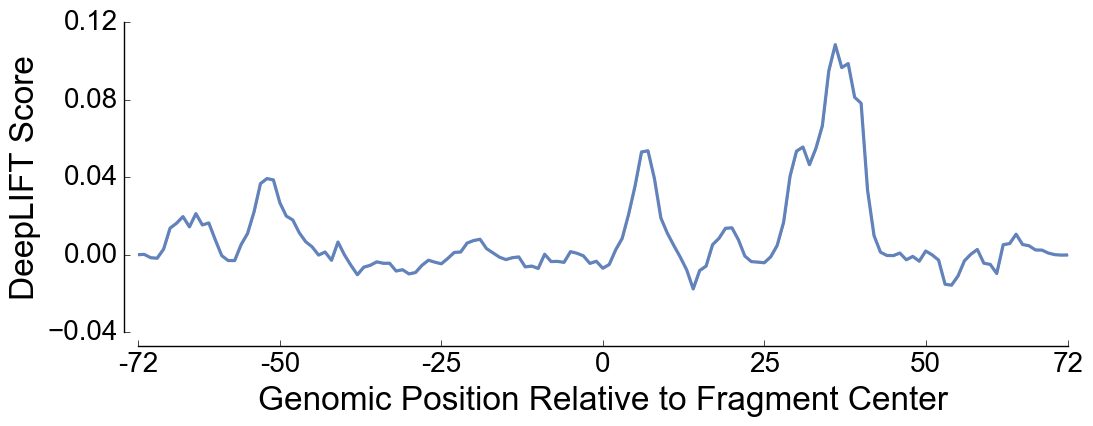

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fragment_idx = 17183
# fragment_idx = 3403
deepliftTrack = np.sum(task_to_deeplift_summedscores[task_idx][fragment_idx], axis=1)

def smoothen(pool, track):
    smooth = np.copy(track)
    for i in range(0, len(smooth)):
        smooth[i] = np.mean(deepliftTrack[max(i - pool/2, 0) : min(i + (pool+1)/2, len(smooth))])
    return smooth

for i in range(3,5,2):
    plt.figure(figsize = (12,4), dpi=300)
    ax = sns.tsplot(smoothen(i, deepliftTrack),
                    color = '#6282bb',
#                     color = '#44549f',
                    lw = 2.3)
#     ax.xaxis.set_visible(False)
#     plt.axhline(0, color='#666666', zorder = -5, linestyle = '-')
    sns.despine(offset = 10)
#     ax.set_ylim([-0.05, 0.13])
    ax.set_ylim([-0.04, 0.12])
    plt.yticks(np.arange(-0.04, 0.16, 0.04), fontsize = 20)
    plt.xticks([0, 22, 47, 72, 97, 122, 144], [-72, -50, -25, 0, 25, 50, 72], fontsize = 20)
    plt.xlabel("Genomic Position Relative to Fragment Center", fontsize = 24)
    plt.ylabel("DeepLIFT Score", fontsize = 24)
#     plt.xticks([22, 47, 72, 97, 122], [-50, -25, 0, 25, 50], fontsize = 20)
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     ax.tick_params(axis='both', which='minor', labelsize=30)
    plt.savefig("../plots/deeplift/vignette_smooth3_17183.png", dpi=300)
    plt.show()

In [9]:
from scipy.stats import mannwhitneyu

def mannwhitney(scores, start, end, include = False):
    if include:
        return mannwhitneyu(scores[start:end], scores, alternative = 'greater')
    return mannwhitneyu(scores[start:end], np.concatenate((scores[:start], scores[end:])), alternative = 'greater')

print mannwhitney(deepliftTrack, 5, 24)
print mannwhitney(deepliftTrack, 74, 84)
print mannwhitney(deepliftTrack, 106, 115)
print mannwhitney(deepliftTrack, 5, 24, include = True)
print mannwhitney(deepliftTrack, 74, 84, include = True)
print mannwhitney(deepliftTrack, 106, 115, include = True)

MannwhitneyuResult(statistic=1794.0, pvalue=0.00023690869670068778)
MannwhitneyuResult(statistic=1024.0, pvalue=0.003271341648653251)
MannwhitneyuResult(statistic=1156.0, pvalue=4.2193874733675729e-06)
MannwhitneyuResult(statistic=1974.5, pvalue=0.0010890021443815702)
MannwhitneyuResult(statistic=1074.0, pvalue=0.0055687803813856528)
MannwhitneyuResult(statistic=1196.5, pvalue=1.4180925358497683e-05)


In [62]:
print np.mean(task_to_deeplift_multipliers[2], axis = (0,1))
print np.mean(task_to_deeplift_summedscores[2], axis = (0,1))

[ 0.00019092  0.00015674  0.00019228  0.0001769 ]
[ 0.00100201 -0.00054913 -0.00090794  0.00117191]


In [13]:
print task_to_deeplift_summedscores[task_idx][idx].shape

(145, 4)


# Validation of DeepLIFT bases with CENTIPEDE motifs
Using DNase peaks for validation of deepLIFT bases.

Got DNase for four cell lines: K562+HepG2 as well as HeLa+MCF7. All from John Stam's lab, ENCODE-processed data.

Peaks are 150bp by default. First, merging the peaks from all files, then getting their sequences with the following bedtools command:

Then, I've added a snippet to this code that checks if seqLen > 145bp (which should be the case for all peaks), if so it takes the middle 145bp. If too short for some reason, skips the sequence.

Some relevant command line commands for these steps:

grep -F "chr8" K562_HepG2_HeLa_MCF7_merged_DNasePeaks.bed >> K562_HepG2_HeLa_MCF7_merged_DNasePeaks_chr8chr18.bed
grep -F "chr18" K562_HepG2_HeLa_MCF7_merged_DNasePeaks.bed >> K562_HepG2_HeLa_MCF7_merged_DNasePeaks_chr8chr18.bed

bedtools getfasta -fi /scratch/users/rmovva/data/hg19.fa -bed \$MPRA/data/dnase/K562_HepG2_HeLa_MCF7_merged_DNasePeaks_chr8chr18.bed -fo \$DL/data/interpretation/centipede/K562_HepG2_HeLa_MCF7_DNasePeaks_chr8chr18.fa

bedtools intersect -a /scratch/users/rmovva/mpra/data/centipede/K562_liftover.bed -b /scratch/users/rmovva/mpra/data/dnase/K562_HepG2_HeLa_MCF7_merged_DNasePeaks_chr8chr18.bed -wa -wb -f 1 -u > chr8chr18_dnasepeaks_centipede_k562_intersectbed.txt



In [48]:
import os
import numpy as np

fasta_seqs = open(os.environ.get("DL") + '/data/interpretation/centipede/K562_HepG2_HeLa_MCF7_DNasePeaks_chr8chr18.fa')

names = []
regions = []
seqs = []
skip = False
i = 0
for line in fasta_seqs:
    if i % 2 == 0:
        name = line.strip()[1:].split('::')[0]
#         region = ('_').join(name.split('_')[:3])
#         if region in regions:
        if False:
            skip = True
        else:
            skip = False
            regions.append(region)
            names.append(name)
    if i % 2 == 1 and skip == False:
        seq = line.strip().upper()
        if len(seq) < 145:
            print("Sequence %d too short; skipping." % i/2)
            names.pop()
            regions.pop()
            i += 1
            continue
        if len(seq) > 145:
            seq = seq[len(seq)/2 - 72 : len(seq)/2 + 73]
        seqs.append(seq)
    i += 1
fasta_seqs.close()

input_data_sequences = np.array(seqs)

In [49]:
print len(input_data_sequences)
print len(input_data_sequences[0])
print input_data_sequences[0]

27886
145
TCAATAGGATATATGTAGATAGATGAGAGAAGACTCATTAGGGGAATTGGTTCACATAATTATGGAGGCTGAGAAGTTACACAATAGCCTGTCTCCAAGTTGGAGAACCAGGAAAGCTGGCAGCATGACTCACTCCAGATATAAA


In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence

modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

# get deeplift model
deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 5 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale


In [51]:
from deeplift.dinuc_shuffle import dinuc_shuffle
import avutils.util

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [2, 5, 8, 11] # 'average' tasks for k5minp, k5sv40, hepminp, hepsv40 respectively

task_to_deeplift_contribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_contribs[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=8,
                                                      batch_size=300,
                                                      progress_update=100000))

100000 reference seqs generated
200000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
100000 reference seqs generated
200000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
100000 reference seqs generated
200000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
100000 reference seqs generated
200000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0


In [53]:
print task_to_deeplift_contribs[2].shape

task_to_deeplift_summedscores = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    task_to_deeplift_summedscores[task_idx] = np.sum(task_to_deeplift_contribs[task_idx], axis=-1)
    
print task_to_deeplift_summedscores[2].shape

(27886, 145, 4)
(27886, 145)


In [54]:
# nt_positions = np.ndarray(shape = task_to_deeplift_summedscores[2].shape, dtype = np.str)
nt_positions = []
# nameType = 'sharpr'
nameType = 'coords'
for i in range(task_to_deeplift_summedscores[2].shape[0]):
    if nameType == 'sharpr':
        fragmentName = names[i].strip().split('_')
        chrom = fragmentName[4]
        center_coord = int(fragmentName[5])
        tile_idx = int(fragmentName[3])
        start_coord = center_coord - 147 + 5*tile_idx
    if nameType == 'coords':
        chrom, coords = names[i].split(':')
        start, end = [int(c) for c in coords.split('-')]
        start_coord = (start + end)/2 - 72
#     nt_positions[i] = np.array([chrom + '_' + str(start_coord + j) for j in range(nt_positions.shape[1])])
    nt_positions.append([chrom + '_' + str(start_coord + j) for j in range(task_to_deeplift_summedscores[2].shape[1])])
    
nt_positions = np.array(nt_positions)

In [108]:
centipedeBases = []
basePath = os.environ.get("DL") + '/data/interpretation/centipede/'
centipedeFragmentIntersections = open(basePath + 'chr8chr18_dnasepeaks_centipede_k562_intersectbed.txt')
for line in centipedeFragmentIntersections:
    line = line.strip().split('\t')
    chrom = line[0]
    start_coord = int(line[1])
    end_coord = int(line[2])
    for coord in range(start_coord, end_coord):
        centipedeBases.append(chrom + '_' + str(coord))
centipedeFragmentIntersections.close()

print len(centipedeBases)
print centipedeBases[:2]
centipedeBases = set(centipedeBases) # Super important to save time in lookup
print len(centipedeBases)

159266
['chr18_3013533', 'chr18_3013534']
66540


In [64]:
import time

scores1d = task_to_deeplift_summedscores[2].ravel()
positions1d = nt_positions.ravel()

n_quantiles = 1910
nts_per_quantile = len(scores1d) / n_quantiles
sorted_idxs = np.argsort(scores1d)
quantile_deeplift_scores = []
percent_overlaps = []
t0 = time.time()
progress_update = n_quantiles / 3
for i in range(n_quantiles):
    if i % progress_update == 0:
        if i > 0:
            print("Quantiles %d to %d took %.3f sec" % (i - progress_update, i, time.time() - t0))
            t0 = time.time()
        print("On quantile %d" % i)
    quantile_idxs = sorted_idxs[i*nts_per_quantile : (i+1)*nts_per_quantile]
    mean_deeplift = np.mean(scores1d[quantile_idxs])
    overlap = sum([1.0 if positions1d[idx] in centipedeBases else 0.0 for idx in quantile_idxs]) / nts_per_quantile
    quantile_deeplift_scores.append(mean_deeplift)
    percent_overlaps.append(overlap)
    
quantile_deeplift_scores = np.array(quantile_deeplift_scores)
percent_overlaps = np.array(percent_overlaps)

On quantile 0
Quantiles 0 to 636 took 0.712 sec
On quantile 636
Quantiles 636 to 1272 took 0.673 sec
On quantile 1272
Quantiles 1272 to 1908 took 0.584 sec
On quantile 1908


In [249]:
print len(quantile_deeplift_scores)
print np.mean(quantile_deeplift_scores), np.std(quantile_deeplift_scores)
print np.mean(percent_overlaps), np.std(percent_overlaps)

from scipy.stats import spearmanr, pearsonr

pos_idxs = quantile_deeplift_scores > 0.02
print np.sum(pos_idxs)
pos_pearson = pearsonr(quantile_deeplift_scores[pos_idxs], percent_overlaps[pos_idxs])
print pos_pearson
neg_idxs = quantile_deeplift_scores <= -0.02
print np.sum(neg_idxs)
neg_pearson = pearsonr(quantile_deeplift_scores[neg_idxs], percent_overlaps[neg_idxs])
print neg_pearson

1910
0.000753829 0.0115722
0.0146465783102 0.0136478579612
87
(0.9889237190937501, 3.3013523405887211e-72)
60
(-0.94294592413990597, 2.191006835840846e-29)


1.64561626524
2.30223050993


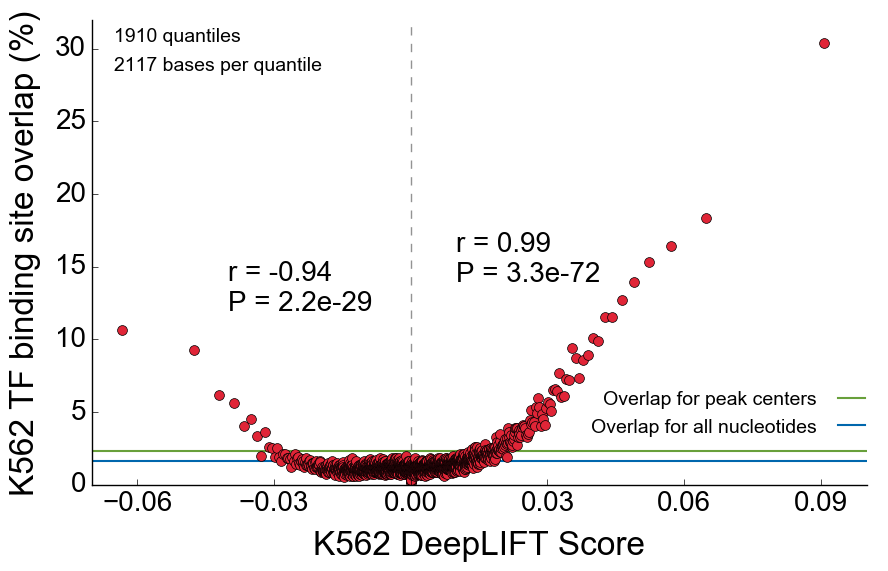

In [289]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from plot_functions import jointplot
    
plt.figure(figsize=(10,6), dpi=300)
    
ax = sns.regplot(x = quantile_deeplift_scores, 
                 y = 100*percent_overlaps,
                 fit_reg = False,
                 scatter_kws = {
                                'marker': 'o',
                                's' : 50,
                                'alpha' : 1.0,
#                                 'color': '#0072b2',
#                                 'color': '#3694e9',
#                                 'color': '#ff8833',
                                'color': '#e02537',
                                'edgecolor': 'k',
                                'linewidth': 0.5
                               }
                 )

ax.set_xlim([-0.07,0.1])
ax.set_ylim([0,32])

n_bases = nt_positions.shape[0]*nt_positions.shape[1]
backgroundFreq = 100.0*len(centipedeBases) / n_bases
centerPositions = []
for name in names:
    chrom, coords = name.split(':')
    start, end = [int(c) for c in coords.split('-')]
    center = (start + end)/2 
    centerPositions.append(chrom + '_' + str(center))
centerFreq = 100*np.sum([1.0 if pos in centipedeBases else 0.0 for pos in centerPositions]) / len(nt_positions)
print backgroundFreq
print centerFreq

# plt.axvline(-0.02, zorder = -5, color = '#939393', linestyle='dashed', lw=1)
# plt.axvline(0.02, zorder = -5, color = '#939393', linestyle='dashed', lw=1)
plt.axvline(0.00, zorder = -5, color = '#939393', linestyle='dashed', lw=1)
plt.axhline(centerFreq, zorder = -5, color = '#68a03b', label='Overlap for peak centers', lw=1.5)
plt.axhline(backgroundFreq, zorder = -5, color = '#0067AD', label='Overlap for all nucleotides', lw=1.5)

plt.xticks(np.arange(-0.06, 0.12, 0.03))
plt.yticks(np.arange(0, 35, 5))

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText = True)

ax.annotate("%d quantiles" % n_quantiles, (-0.065, 30.5), fontsize=14)
ax.annotate("%d bases per quantile" % (n_bases / n_quantiles), (-0.065, 28.5), fontsize=14)

ax.annotate("r = %.2f\nP = %.1e" % neg_pearson, (-0.04, 12), fontsize=20)
ax.annotate("r = %.2f\nP = %.1e" % pos_pearson, (0.01, 14), fontsize=20)

ax.set_xlabel('K562 DeepLIFT Score', fontsize = 24)
ax.set_ylabel('K562 TF binding site overlap (%)', fontsize = 24)

ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

sns.despine()

legend = plt.legend(bbox_to_anchor=(1.028, 0.24),
           bbox_transform=ax.transAxes,
           frameon=False,
           fontsize=14)

plt.draw()

# shift = max([t.get_window_extent().width for t in legend.get_texts()])
# print shift
# for t in legend.get_texts():
#     t.set_ha('right') # ha is alias for horizontalalignment
#     t.set_position((shift,0))

vp = legend._legend_box._children[-1]._children[0] 
for c in vp._children: 
    c._children.reverse() 
vp.align="right" 

plt.savefig('../plots/sharpr_scatterplots/centipede/' + 
            'chr8chr18dnase_1910quantiles_scatterplot.png',
            dpi=300)
plt.show()

# jointplot(quantile_deeplift_scores, 100*percent_overlaps,
#           out_pdf = '../plots/sharpr_scatterplots/centipede/chr8chr18dnase_1910quantiles.png',
#           show = True,
#           alpha = 0.5,
#           despine=False,
#           square=False,
#           cor='none',
#           x_label='K562 DeepLIFT Score',
#           y_label='K562 CENTIPEDE binding site overlap (%)',
#           figsize=6,
#           color = 'b',
# #           color = '#276ba5',
#           tickfont = 14,
#           kde=False)

# Scoring TF motifs with DeepLIFT

Figure goals from this analysis:
1. Arrow-shape plots of deepLIFT score vs. nucleotide position relative to motif center for activating motifs, similar v-shape plots for repressive motifs. (analogous to Sharpr Figure 4b).
2. Bar plots comparing average deepLIFT score in real TF motifs vs. shuffled TF motifs.
3. Scatter plot showing motif average score in HepG2 cells vs. K562 cells - cell-type specific TF activity. (analogous to Sharpr Figure 4a.)
4. Potentially, analysis of motifs with dual activator-repressor function. Not yet sure about visualization.

First going to try using training set only. That is, compute average score for all motifs that completely overlap a Sharpr fragment in the training set. Here are the steps to do so:
1. Convert Pouya Kheradpour's motif matches file (http://compbio.mit.edu/encode-motifs/) to BED format 1a. Get motif matches on chr1 from the converted BED file
2. Convert split file to BED format - only chromosome 1
3. bedtools intersect -a matches-with-controls-bed-chr1.txt.gz -b $DL/splits/sharpr_znormed_jul23/chr1_train_indexed_bed.txt -wa -wb -f 1 -s > sharpr_motif_intersection_chr1.txt.gz
4. Create a dictionary where the keys are motifs and the values are 2D arrays of the scores where rows are motif instances and columns are scores for each base pair in the motif. Will start with no keys/values, add keys as each new motif comes in.
4a. Create a second dictionary that gets deeplift scores for the broader context around the motif to show the characteristic arrow shape that the Sharpr paper shows. 
5. Each line in the sharpr_motif_intersection is a specific motif in a specific sharpr fragment. Iterate through said file, getting the index from the score column of the sharpr fragment, and getting the start coordinate of the sharpr fragment from the start column as well. Then, the deeplift score indices will be:
deepliftscores[task_idx][fragment_idx][(motif_start - fragment_start) : (motif_end - fragment_start)]
(there may be an off-by-one error here if the two use different coordinate systems, but that should be noticeable / ok.)
Check if the motif_start - 50 > fragment_start and motif_end + 50 < fragment_end. If so, get deeplift scores for 
deepliftscores[task_idx][fragment_idx][(motif_start - fragment_start - 50) : (motif_end - fragment_start + 50)]
and put those into the second dictionary.

6. For each motif, compute average scores across numpy axis 1 - at each base pair relative to motif center, what's the avg score. Should drop off with increasing distance from motif center. This is using the -50 +50bp dictionary.

7. seaborn.tsplot of dictionary 2 for Figure Goal 1; seaborn.scatterplot of dictionary 1 for Figure Goal 3; cherry pick some of the top motifs and do seaborn.barplot for figure goal 2



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
import os, sys
import pandas as pd

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home/users/rmovva/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.3.1611-Core-x86_64-2.7.13-64/tmp0vIZT5/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '121422' (I am process '143670')
/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:82:00.0)


In [8]:
import h5py

train_path = "../hdf5files/sharpr_znormed_jul23/train_data.hdf5"
data = h5py.File(train_path)

In [ ]:
modelName = "record_13_model_bgGhy_"
modelJson = "../model_files/sharpr_znormed_jul23/" + modelName + "modelJson.json"
modelWeights = "../model_files/sharpr_znormed_jul23/" + modelName + "modelWeights.h5"

keras_model = kc.load_keras_model(modelWeights, json=modelJson)

# normalize weights
W, b = keras_model.layers[0].get_weights()
mean_W = np.mean(W, axis = -2)
W = W - mean_W[:, :, None, :]
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

import momma_dragonn
import h5py
# load the validation set
train_path = "../hdf5files/sharpr_znormed_jul23/train_data.hdf5"
data = h5py.File(train_path)

deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

deeplift_prediction_function = deeplift_model.get_prediction_function(input_layer_idx = 0,
                                                                      output_layer_idx = -1
                                                                     )

preds = deeplift_prediction_function([data['X/sequence']], batch_size = 500)

deeplift_scoring_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx = 0,
                                                                target_layer_idx = -1
                                                               )

In [ ]:
letter_list = ['A', 'C', 'G', 'T']

def convert_one_hot_seq_to_acgt(one_hot_seq):
    seq = ''
    for i in range(len(one_hot_seq)):
        seq += letter_list[np.argmax(one_hot_seq[i])]
    return seq

import time
t0 = time.time()
input_data_sequences = []
print_interval = int(1e5)
for (i, seq) in enumerate(np.array(data['X/sequence'])):
    if i % print_interval == 0 and i > 0:
        print ("Converting sequences " + str(i - print_interval) +
               " to " + str(i) + " from one-hot to ACGT strings took " +
               str(round(time.time() - t0, 3)) + "s.")
        t0 = time.time()
    char_seq = convert_one_hot_seq_to_acgt(seq)
    input_data_sequences.append(char_seq)
    
input_data_sequences = np.array(input_data_sequences)

import avutils
from deeplift.dinuc_shuffle import dinuc_shuffle

seed = 0
deeplift_many_refs_func = deeplift.util.get_shuffle_seq_ref_function(
                                score_computation_function=deeplift_scoring_func, #supply any deeplift scoring function
                                shuffle_func=deeplift.dinuc_shuffle.dinuc_shuffle,
                                seed=seed,
                                one_hot_func=lambda x: np.array([avutils.util.seq_to_one_hot(seq) for seq in x]) #theano_seq_to_2d_image, seq_to_one_hot
                            )

task_idxs = [2, 5, 8, 11] # 'average' tasks for k5minp, k5sv40, hepminp, hepsv40 respectively

task_to_deeplift_contribs = OrderedDict()
for task_idx in task_idxs:
    task_to_deeplift_contribs[task_idx] = np.array(deeplift_many_refs_func(
                                                      task_idx = task_idx,
                                                      input_data_sequences=input_data_sequences,
                                                      num_refs_per_seq=8,
                                                      batch_size=500,
                                                      progress_update=1000000))

In [ ]:
import pandas
import os
import time

os.system("mkdir ../deeplift_scores/%s" % modelName[:-1])
t0 = time.time()
for task_idx in task_to_deeplift_contribs:
#     if task_idx == 2:
#         continue
    shape = task_to_deeplift_contribs[task_idx].shape
    df = pd.DataFrame(np.reshape(task_to_deeplift_contribs[task_idx], (shape[0], -1)))
    df.to_csv("../deeplift_scores/%s/contribs_reshaped_task%d.tab" % (modelName[:-1], task_idx),
              sep = '\t',
#               compression = 'gzip',
              header = False,
              index = False # I initially forgot to set this to false, hence the 1: in the next cell
             )
    print("Writing deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()

In [2]:
import pandas
import time

modelName = "record_13_model_bgGhy_" 

task_to_deeplift_contribs = OrderedDict()
t0 = time.time()
for task_idx in [2, 5, 8, 11]:
    path = '../deeplift_scores/%s/contribs_reshaped_task%d.tab' % (modelName[:-1], task_idx)
    task_to_deeplift_contribs[task_idx] = pd.read_csv(path, 
                                                      sep = '\t',
                                                      header = None).values
    task_to_deeplift_contribs[task_idx] = task_to_deeplift_contribs[task_idx][:, 1:].astype(np.float32)
    print task_to_deeplift_contribs[task_idx].shape
    task_to_deeplift_contribs[task_idx] = np.reshape(task_to_deeplift_contribs[task_idx], (-1, 145, 4))
    print("Reading in deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
    t0 = time.time()

(914348, 580)
Reading in deepLIFT scores for task 2 took 120.037 sec
(914348, 580)
Reading in deepLIFT scores for task 5 took 120.028 sec
(914348, 580)
Reading in deepLIFT scores for task 8 took 119.797 sec
(914348, 580)
Reading in deepLIFT scores for task 11 took 121.117 sec


In [9]:
print task_to_deeplift_contribs[2].shape
import time

task_to_deeplift_summedscores = OrderedDict()
task_to_deeplift_seqcontribs = OrderedDict()
for task_idx in task_to_deeplift_contribs:
    t0 = time.time()
    task_to_deeplift_summedscores[task_idx] = np.sum(task_to_deeplift_contribs[task_idx], axis=-1)
    print("Took %.3f sec" % (time.time() - t0))
    t0 = time.time()
    task_to_deeplift_seqcontribs[task_idx] = task_to_deeplift_contribs[task_idx]*np.array(data['X/sequence'])
    print("Took %.3f sec" % (time.time() - t0))
    t0 = time.time()
    
print task_to_deeplift_summedscores[2].shape
print task_to_deeplift_seqcontribs[2].shape

(914348, 145, 4)
Took 0.644 sec
Took 42.921 sec
Took 0.637 sec
Took 15.494 sec
Took 0.764 sec
Took 15.568 sec
Took 0.752 sec
Took 15.737 sec
(914348, 145)
(914348, 145, 4)


In [10]:
import time
import sys

motif_scores = OrderedDict()
motifwcontext_scores = OrderedDict()
for task_idx in task_to_deeplift_summedscores:
    motif_scores[task_idx] = {}
    motifwcontext_scores[task_idx] = {}

motifPath = '/scratch/users/rmovva/mpra/data/pouya_motif_matches/'
motifsToScore = open(motifPath + 'sharprtrain_motif_intersection_all.txt', 'r')
i = 0
t0 = time.time()
progress_update = 2000000
previous_motif = ('', '')
for motif in motifsToScore:
    if i % progress_update == 0 and i > 0:
        print("Scoring motifs %d to %d took %.3f s" % (i - progress_update, i, time.time() - t0))
        t0 = time.time()
    motif = motif.strip().split('\t')
    motif_start = int(motif[1])
    motif_end = int(motif[2])
    motif_name = motif[3]
#     # Prevent duplicate scoring of a motif with a different tile's deeplift scores
#     if motif_name == previous_motif[0] and motif_start == previous_motif[1]:
#         i += 1
#         continue
#     previous_motif = (motif_name, motif_start)
    fragment_start = int(motif[7])
    fragment_end = int(motif[8])
    fragment_idx = int(motif[-2])
    
#     canGetContext = (motif_start - fragment_start >= 50 and motif_end + 50 <= fragment_end)
    
    for task_idx in motif_scores:
        if motif_name not in motif_scores[task_idx]:
            motif_scores[task_idx][motif_name] = []
        scores = task_to_deeplift_summedscores[task_idx][fragment_idx][(motif_start - fragment_start) : (motif_end - fragment_start)]
        motif_scores[task_idx][motif_name].append(scores)
#         print scores
        
        # instead of worrying about context, just get as many bases as possible from -72 to +72
        # bases that are outside of the fragment are left as np.nans, and therefore we use np.nanmean later
        if motif_name not in motifwcontext_scores[task_idx]:
            motifwcontext_scores[task_idx][motif_name] = []
        scores = np.empty(2*(fragment_end - fragment_start) - 1, dtype = np.float32)
        scores[:] = np.NAN
        motifRelativePosition = (motif_start + motif_end)/2 - fragment_start
#         print motifRelativePosition
        deepliftTrack = task_to_deeplift_summedscores[task_idx][fragment_idx]
        scores[len(scores)/2 - motifRelativePosition : len(scores) - motifRelativePosition] = deepliftTrack
#         print len(scores)
#         print np.sum(scores > -1)
#         print scores
#         sys.exit(0)
        motifwcontext_scores[task_idx][motif_name].append(scores)
        
#         if canGetContext:
#             if motif_name not in motifwcontext_scores[task_idx]:
#                 motifwcontext_scores[task_idx][motif_name] = []
#             context_start = motif_start - fragment_start - 50
#             context_end = motif_end - fragment_start + 50
#             scores = task_to_deeplift_summedscores[task_idx][fragment_idx][context_start : context_end]
#             motifwcontext_scores[task_idx][motif_name].append(scores)
    i += 1

motifsToScore.close()
            
for task_idx in motif_scores:
    for motif_name in motif_scores[task_idx]:
        motif_scores[task_idx][motif_name] = np.array(motif_scores[task_idx][motif_name])
        
    for motif_name in motifwcontext_scores[task_idx]:
        motifwcontext_scores[task_idx][motif_name] = np.array(motifwcontext_scores[task_idx][motif_name])
        

Scoring motifs 0 to 2000000 took 54.604 s
Scoring motifs 2000000 to 4000000 took 54.901 s
Scoring motifs 4000000 to 6000000 took 54.806 s
Scoring motifs 6000000 to 8000000 took 54.966 s
Scoring motifs 8000000 to 10000000 took 55.050 s
Scoring motifs 10000000 to 12000000 took 55.341 s
Scoring motifs 12000000 to 14000000 took 55.151 s
Scoring motifs 14000000 to 16000000 took 56.812 s


In [11]:
for task_idx in [2]:
    print("Number of motifs without context in >= 1 fragment: %d" % len(motif_scores[task_idx].keys()) )
    print("Number of motifs with 50bp context in >= 1 fragment: %d" % len(motifwcontext_scores[task_idx].keys()) )
    meanWoContext = np.mean(np.array([len(motif_scores[task_idx][motif_name]) for motif_name in motif_scores[task_idx]]))
    print("Average number of instances of motifs without context: %.3f" % meanWoContext)
    meanWContext = np.mean(np.array([len(motifwcontext_scores[task_idx][motif_name]) for motif_name in motifwcontext_scores[task_idx]]))
    print("Average number of instances of motifs with context: %.3f" % meanWContext)

Number of motifs without context in >= 1 fragment: 18862
Number of motifs with 50bp context in >= 1 fragment: 18862
Average number of instances of motifs without context: 867.067
Average number of instances of motifs with context: 867.067


In [ ]:
for motif_name in motif_scores[2]:
    if motif_name.find('NRF1_disc2') != -1:
        print motif_name, len(motif_scores[2][motif_name])

In [12]:
# contains the average deepLIFT scores for each instance of the motif - gives distribution of motif scores
average_motif_scores = OrderedDict() 
# contains the average deepLIFT score across all instances of the motif at each base pair in the motif
average_motif_scores_bp = OrderedDict()
# contains the average deepLIFT score across all instances of the motif + 50bp context
average_motifwcontext_scores_bp = OrderedDict()

for task_idx in motif_scores:
    print("On task %d" % task_idx)
    average_motif_scores[task_idx] = {}
    average_motif_scores_bp[task_idx] = {}
    average_motifwcontext_scores_bp[task_idx] = {}
    for motif_name in motif_scores[task_idx]:
        average_motif_scores[task_idx][motif_name] = np.mean(motif_scores[task_idx][motif_name], axis=1)
        average_motif_scores_bp[task_idx][motif_name] = np.mean(motif_scores[task_idx][motif_name], axis=0)
    for motif_name in motifwcontext_scores[task_idx]:
        average_motifwcontext_scores_bp[task_idx][motif_name] = np.nanmean(motifwcontext_scores[task_idx][motif_name], axis=0)
        for bp_idx in np.arange(289)[np.isnan(average_motifwcontext_scores_bp[task_idx][motif_name])]:
            average_motifwcontext_scores_bp[task_idx][motif_name][bp_idx] = 0

On task 2


/home/users/rmovva/.local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: Mean of empty slice


On task 5
On task 8
On task 11


## Get top activating/repressive motifs per task

In [13]:
# for each motif, take average of deeplift scores across all positions across all instances
# this gives a score for each combination of (TF motif, celltype, promoter)
# can then sort the TFs by score to find most activating and most repressing
aggregate_motif_scores = OrderedDict()

for task_idx in motif_scores:
    aggregate_motif_scores[task_idx] = [(motif_name, np.mean(average_motif_scores[task_idx][motif_name])) 
                                        for motif_name in average_motif_scores[task_idx]
                                        if motif_name.find('_C') == -1]
    aggregate_motif_scores[task_idx] = sorted(aggregate_motif_scores[task_idx],
                                                  key = lambda x: x[1])[::-1]

In [ ]:
n_print = 10
for task_idx in aggregate_motif_scores:
    print("On task %d, activating" % task_idx)
    for i in range(n_print):
        print(aggregate_motif_scores[task_idx][i])
    print
    print("On task %d, repressive" % task_idx)
    for i in range(n_print):
        print(aggregate_motif_scores[task_idx][-(i+1)])
    print

In [20]:
print np.mean(average_motif_scores[2]['ETS_1']), np.std(average_motif_scores[2]['ETS_1'])
print np.mean(average_motif_scores[2]['ETS_1_C1']), np.std(average_motif_scores[2]['ETS_1_C1'])
print np.mean(average_motif_scores[2]['GATA_known21']), np.std(average_motif_scores[2]['GATA_known21'])
print np.mean(average_motif_scores[2]['GATA_known21_C1']), np.std(average_motif_scores[2]['GATA_known21_C1'])
print np.mean(average_motif_scores[8]['HNF4_known3']), np.std(average_motif_scores[8]['HNF4_known3'])
print np.mean(average_motif_scores[8]['HNF4_known3_C4']), np.std(average_motif_scores[8]['HNF4_known3_C4'])
print np.mean(average_motif_scores[8]['REST_disc2']), np.std(average_motif_scores[8]['REST_disc2'])
print np.mean(average_motif_scores[8]['REST_disc2_C1']), np.std(average_motif_scores[8]['REST_disc2_C1'])
print np.mean(average_motif_scores[8]['SIN3A_disc7']), np.std(average_motif_scores[8]['SIN3A_disc7'])
print np.mean(average_motif_scores[8]['SIN3A_disc7_C1']), np.std(average_motif_scores[8]['SIN3A_disc7_C1'])

0.00929078 0.00842241
-0.000497909 0.00378683
0.00731715 0.00319154
0.00573436 0.00366916
0.00661717 0.00540624
-0.00136068 0.00284899
-0.00545936 0.00349258
-0.000327346 0.00280463
-4.09127e-05 0.00414636
0.00292928 0.00580864


## Motif arrow plots, showing score at each bp

In [14]:
def smoothen(pool, track):
    smooth = np.copy(track)
    for i in range(0, len(smooth)):
        smooth[i] = np.nanmean(deepliftTrack[max(i - pool/2, 0) : min(i + (pool+1)/2, len(smooth))])
    return smooth

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/seaborn/algorithms.py:76: RuntimeWarning: Mean of empty slice
  boot_dist.append(func(*sample, **func_kwargs))
/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/seaborn/timeseries.py:309: RuntimeWarning: Mean of empty slice
  central_data = estimator(df_c.values, axis=0)


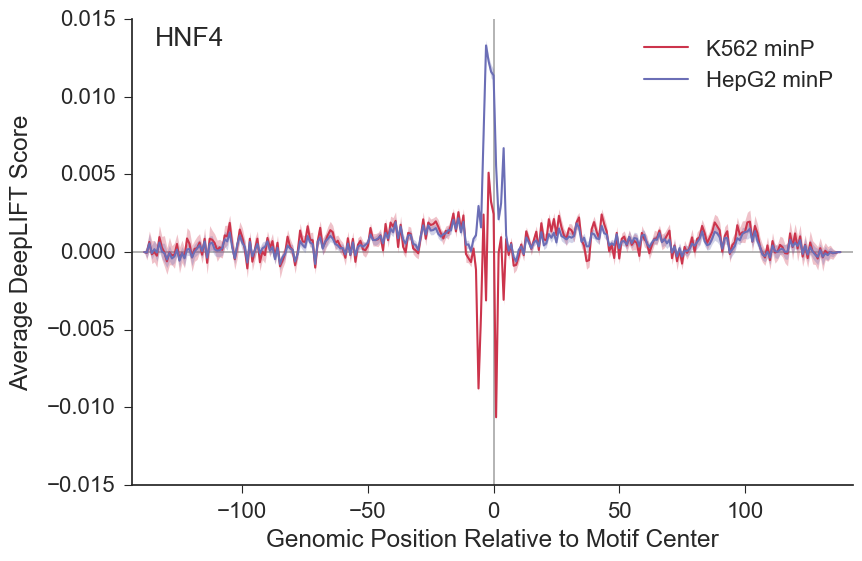

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

task_names = {2: 'K562 minP', 5: 'K562 SV40P', 8: 'HepG2 minP', 11: 'HepG2 SV40P'}

plt.figure(figsize=(9,6), dpi=300)
# sns.set(font_scale=1)
sns.set(context='paper', 
        style='ticks', 
        font='Arial', 
        font_scale=2, 
        color_codes="dark",
        )
task_idxs = [2,8]
# motif_names = ['GATA_disc1', 'GATA_disc1_C1']
motif_names = ['HNF4_disc1']#, 'ETS_1_C1']
# motif_names = ['HNF4_known3', 'HNF4_known3_C4']
colors = ['#CC344C', '#6B6EB6', 'b', 'c']
conditions = list(itertools.product(task_idxs, motif_names))
context_scores_by_motif = [motifwcontext_scores[task_idx][motif_name] 
                           for (task_idx, motif_name) in conditions]
context_len = 144
offset = 0
context_len -= offset/2
# smoothen_pool = 3
for (i, context_scores) in enumerate(context_scores_by_motif):
    length = context_scores.shape[1]
    ax = sns.tsplot(context_scores[:, (length/2 - context_len + offset/2):(length/2 + context_len + offset/2)], 
#                     time = np.arange(-1*length/2, length/2),
                    time = np.arange(-context_len, context_len),
                    value = 'Average DeepLIFT Score',
                    condition =  task_names[conditions[i][0]],
                    color = colors[i],
                    ci = 95,
#                     ci = 'sd',
                    n_boot = 100,
                    err_style = 'ci_band',
                    err_kws = {'linewidth': 0, 'alpha': 0.3},
                    interpolate = True,
                    estimator = np.nanmean,
                    linewidth = 1.5
                   )
    
ax.text(0.08, 0.96, conditions[0][1].split('_')[0],
        ha = 'center', va = 'center',
        transform = ax.transAxes)
# plt.xticks([-100, -50, 0, 50, 100])
# plt.yticks(np.arange(-0.02, 0.011, 0.005))
plt.axvline(0, zorder = -5, color = '#B3B3B3')
plt.axhline(0, zorder = -5, color = '#B3B3B3')
plt.xlabel('Genomic Position Relative to Motif Center')
sns.despine(offset=0);
ax.yaxis.labelpad=10
plt.tight_layout()
plt.savefig('../model_files/sharpr_znormed_jul23/interpretation/motifscore_arrowplots/' + 
            '%s_tasks%s_%dbpcontext_%doffset.png' % (conditions[0][1], 
                                            'and'.join([str(i) for i in task_idxs]),
                                            context_len,
                                            offset), 
            dpi=300)
plt.show()

## Motif-motif scatter plot.

In [16]:
# Create scatter plot of all motif scores
# Here the scores are the total avg deepLIFT scores over the entire motif

task_sets = [[2,5], [8,11]]
motif_names_list = []
motif_scores_set1 = []
motif_scores_set2 = []
selected_idxs = []
freeze_motifs = ['ETS_known12', 'BRCA1_disc1', 'AP1_known3', # activators
                 'SIN3A_disc1', 'REST_known4', # repressors
                 'RUNX1_6', 'GATA_known16', # k562-specific
                 'HNF4_disc1', 'TP53_2' # hepg2-specific
                ]
freeze_idxs = []
real_motif_idx = -1
for (i, motif_name) in enumerate(average_motif_scores_bp[task_sets[0][0]].keys()):
    if motif_name.find('_C') != -1:
        continue
    real_motif_idx += 1
    motif_names_list.append(motif_name)
    score_1 = np.mean([np.sum(average_motif_scores_bp[task_idx][motif_name]) for task_idx in task_sets[0]])
    score_2 = np.mean([np.sum(average_motif_scores_bp[task_idx][motif_name]) for task_idx in task_sets[1]])
    motif_scores_set1.append(score_1)
    motif_scores_set2.append(score_2)
    if (
        (score_1 > 0.2 and score_2 > 0.2 and score_1 < 0.3 and score_2 < 0.3)
        or (score_1 < -0.03 and score_2 < -0.03) 
        or (np.abs(score_1) > 6*np.abs(score_2) and np.abs(score_1) > 0.035)
        or (6*np.abs(score_1) < np.abs(score_2) and np.abs(score_2) > 0.05)
       ):
        selected_idxs.append(real_motif_idx)
#         print motif_name
#         print score_1
#         print score_2
    if motif_name in freeze_motifs:
        freeze_idxs.append(real_motif_idx)
            
motif_scores_set1 = np.array(motif_scores_set1)
motif_scores_set2 = np.array(motif_scores_set2)
print len(motif_scores_set1)
print len(motif_scores_set2)
print len(selected_idxs)

1934
1934
97


SpearmanrResult(correlation=0.86561904548364899, pvalue=0.0)


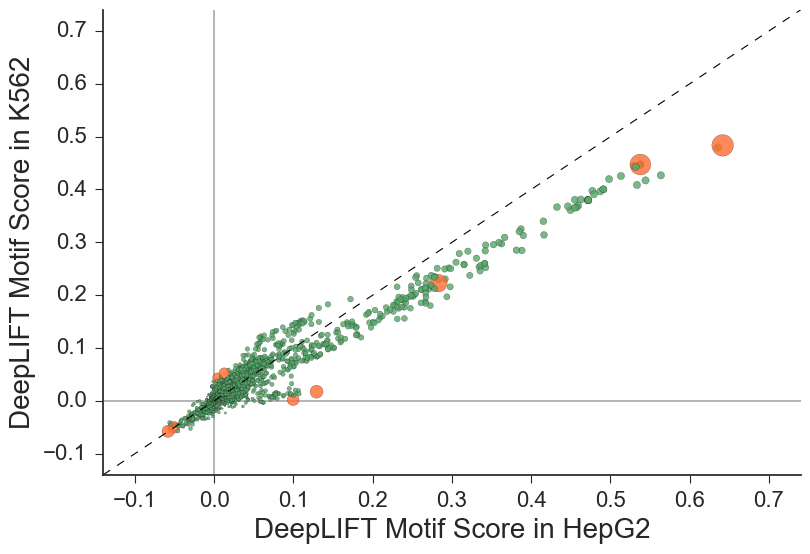

In [17]:
from plot_functions import jointplot, regplot
from scipy.stats import spearmanr

plt.figure(figsize=(9,6),dpi=300)

sns.set(context='paper', 
        style='ticks', 
        font='Arial', 
        font_scale=2, 
        color_codes="dark",
        )

# show_idxs = np.random.choice(selected_idxs, 5, replace=False)
show_idxs = freeze_idxs
# colorlist = ['#ff5913' if idx in show_idxs else 'g' for idx in range(len(motif_scores_set1))]
colorlist = ['#FF6C2F' if idx in show_idxs else 'g' for idx in range(len(motif_scores_set1))]
sizelist = 2*np.sqrt(200.0*np.abs(motif_scores_set1 + motif_scores_set2))
for idx in show_idxs:
    sizelist[idx] *= 8

print spearmanr(motif_scores_set1, motif_scores_set2)
    
ax = sns.regplot(y = motif_scores_set1, x = motif_scores_set2,
            fit_reg = False,
            scatter_kws = {
#                            's': 2*np.sqrt(200.0*np.abs(motif_scores_set1 + motif_scores_set2)),
                           's': sizelist,
                           'alpha' : 0.8,
#                            'color': '#ff7913', # orange
#                            'color': '#88b04b', # greenery
#                            'color': 'g', # greenery
                           'color': colorlist,
                           'edgecolor': 'k',
                           'linewidth': 0.2
#                            'edgecolors': len(motif_scores_set1)*['k']
                          }
           )

axlim = [-0.14, 0.74]
ax.set_xlim(axlim)
ax.set_ylim(axlim)
ax.plot(axlim, axlim, linestyle='--', color='black', linewidth = 0.8)

plt.axvline(0, zorder = -5, color = '#B3B3B3')
plt.axhline(0, zorder = -5, color = '#B3B3B3')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

# for idx in show_idxs:
#     ax.annotate(motif_names_list[idx], (motif_scores_set1[idx], motif_scores_set2[idx]), fontsize=12)
    
# ax.annotate('origin', (0,0))

# ax.set_xlabel('DeepLIFT Motif Score in K562', fontsize = 20, color = '#BC243C')
# ax.set_ylabel('DeepLIFT Motif Score in HepG2', fontsize = 20, color = '#5B5EA6')
ax.set_ylabel('DeepLIFT Motif Score in K562', fontsize = 20)
ax.set_xlabel('DeepLIFT Motif Score in HepG2', fontsize = 20)

sns.despine()

plt.savefig('../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
            'K562vsHepG2_scatterplot_scaledpoints_unlabeled_uncoloredaxlabels.png',
            dpi=300)
plt.show()

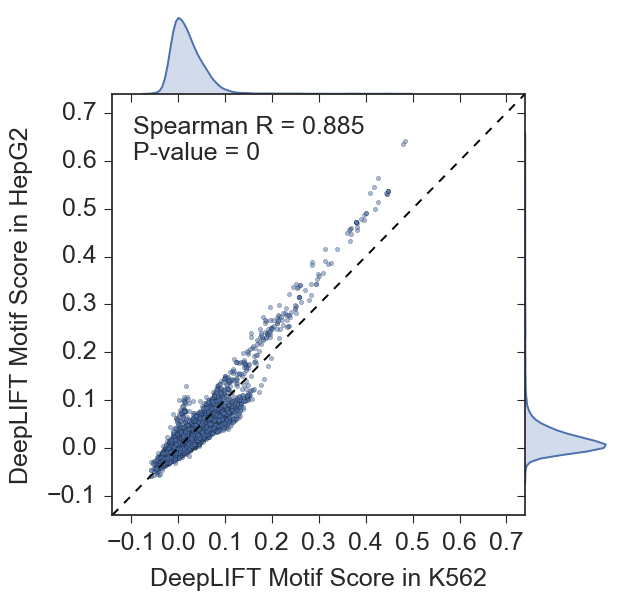

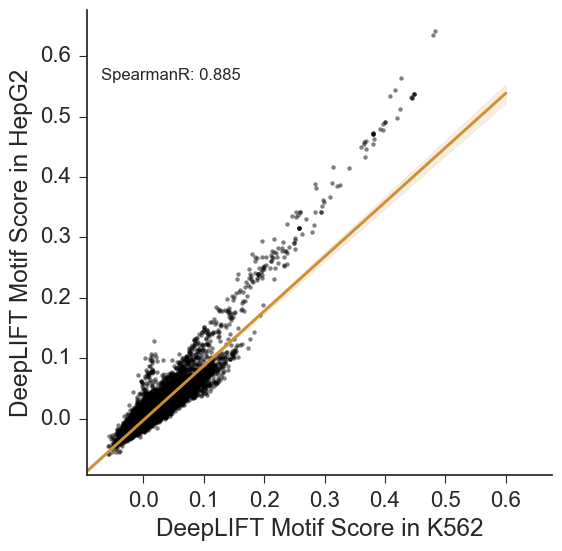

In [410]:
jointplot(np.array(motif_scores_set1), 
          np.array(motif_scores_set2),
          out_pdf = '../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
                    'K562vsHepG2_jointplot.png',
          show=True,
          square=True,
          despine=False,
          cor='spearmanr',
          x_label='DeepLIFT Motif Score in K562',
          y_label='DeepLIFT Motif Score in HepG2',
          figsize=6,
          axlim=[-0.14, 0.74],
          color = 'b')

regplot(np.array(motif_scores_set1), 
        np.array(motif_scores_set2),
        out_pdf = '../model_files/sharpr_znormed_jul23/interpretation/motifscore_scatterplots/' + 
                  'K562vsHepG2_regplot.png',
        show=True,
        square=True,
#         despine=False,
        cor='spearmanr',
        x_label='DeepLIFT Motif Score in K562',
        y_label='DeepLIFT Motif Score in HepG2',
        figsize=(6,6))

## Barplots comparing motif scores across tasks and compare to controls

In [18]:
# contains the average deepLIFT scores for each instance of the motif - gives distribution of motif scores
# average_motif_scores[task_idx][motif_name]

from collections import OrderedDict

df_data = {'motif': [], 'score': [], 'task': []}

motifs = ['ETS_1', 'HNF4_disc1', 'REST_known4']
motifs_expanded = []
for curated_motif in motifs:
    motif_with_controls = []
    for motif_name in average_motif_scores[2]:
        if motif_name.find(curated_motif) != -1:
            motif_with_controls.append(motif_name)
    motifs_expanded.append(motif_with_controls)

tasks = [2, 8]
for task_idx in tasks:
    for motif_set in motifs_expanded:
        for motif in motif_set:
            scores = list(average_motif_scores[task_idx][motif])# + list(average_motif_scores[task_idx+3][motif])
            df_data['motif'] += [motif.split('_')[0]]*len(scores)
            df_data['score'] += scores
            cell = ('K562' if task_idx == 2 else 'HepG2')
            motiftype = ('shuffled motif' if motif.find('_C') != -1 else 'real motif')
            condition = '%s, %s' % (cell, motiftype)
            df_data['task'] += [condition]*len(scores)
            
# print np.mean(average_motif_scores[2]['ETS_1']), np.std(average_motif_scores[2]['ETS_1'])
# print [len(df_data[key]) for key in df_data]
# print set(df_data['task'])

12


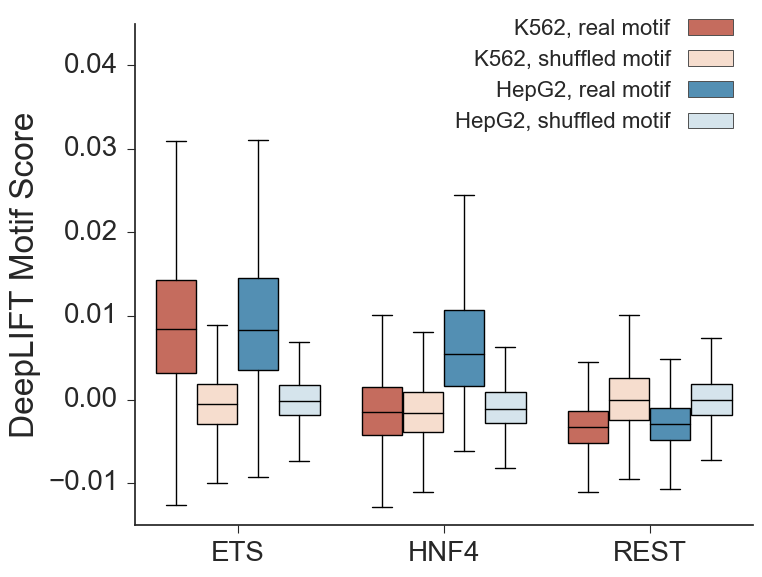

In [21]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame.from_dict(df_data)

df.to_csv('../plots/deeplift/motif_boxplots/ETS_HNF_REST_data.csv',
          sep = ',')

sns.set(context='paper', 
        style='ticks', 
        font='Arial', 
        font_scale=2, 
        color_codes="dark",
        )

cols = ['#b92f2b', '#e7aa64', '#579352', '#4166a6']
cols = list(sns.color_palette('muted'))
cols = list(sns.color_palette('RdBu', n_colors = 4))
cols[2], cols[3] = cols[3], cols[2]
plt.figure(figsize = (8, 6), dpi=300)
ax = sns.boxplot(data = df, 
            x = 'motif', 
            y = 'score', 
            hue = 'task',
            palette = cols,
#             palette = 'muted',
#             color = '#b92f2b',
            color = 'r',
#             hue_order = ['K562, real motif', 'HepG2, real motif', 'K562, control motif', 'HepG2, control motif'],
            hue_order = ['K562, real motif', 'K562, shuffled motif', 'HepG2, real motif', 'HepG2, shuffled motif'],
            fliersize = 0,
            width = 0.8,
            orient = 'v',
#             ci = 99
           )

print len(ax.artists)
for i,box in enumerate(ax.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = box.get_facecolor()
    box.set_edgecolor('black')
#     box.set_edgecolor(cols[i%4])
    box.set_linewidth(1)
#     box.set_linewidth(2)
#     box.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color('black')
#         line.set_color(cols[i%4])
        line.set_mfc('black')
#         line.set_mfc(cols[i%4])
        line.set_mec('black')
#         line.set_mec(cols[i%4])
        line.set_linewidth(1)
#         line.set_linewidth(2)
        if j%6 == 2 or j%6 == 3:
            line.set_color('black')
#             line.set_linewidth(2)


# Also fix the legend
for legpatch in ax.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

sns.despine()
# sns.despine(offset = 20)
# legend = plt.legend()
legend = plt.legend(bbox_to_anchor=(1, 1.05),
                    bbox_transform=ax.transAxes)

vp = legend._legend_box._children[-1]._children[0] 
for c in vp._children: 
    c._children.reverse() 
vp.align="right" 

# ax.set_ylim(-0.02, 0.04)
ax.set_ylim(-0.015, 0.045)

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel("", fontsize = 24)
plt.ylabel("DeepLIFT Motif Score", fontsize = 24)

plt.tight_layout()
plt.savefig('../plots/deeplift/motif_barplots/%s_real_shuffled.png' % '_'.join(motifs), dpi=300)
plt.show()

In [33]:
from scipy.stats import mannwhitneyu

for motif in ['ETS', 'HNF4', 'REST']:
    for cell in ['K562', 'HepG2']:
        print(motif, cell)
        realScores = df[(df['motif'] == motif) & (df['task'] == '%s, real motif' % cell)]['score']
        shuffledScores = df[(df['motif'] == motif) & (df['task'] == '%s, shuffled motif' % cell)]['score']
        print(len(realScores))
        print(len(shuffledScores))
        print(mannwhitneyu(realScores, shuffledScores, alternative = 'two-sided'))
# mannwhitneyu(df[df['motif'] == 'ETS' & df['task'] == 'K562, real motif']['score'])

('ETS', 'K562')
3967
1852
MannwhitneyuResult(statistic=6366858.0, pvalue=0.0)
('ETS', 'HepG2')
3967
1852
MannwhitneyuResult(statistic=6488074.0, pvalue=0.0)
('HNF4', 'K562')
3609
7029
MannwhitneyuResult(statistic=12947902.0, pvalue=0.07826492419540064)
('HNF4', 'HepG2')
3609
7029
MannwhitneyuResult(statistic=21781867.0, pvalue=0.0)
('REST', 'K562')
1716
3705
MannwhitneyuResult(statistic=1566883.5, pvalue=9.8861191300978033e-199)
('REST', 'HepG2')
1716
3705
MannwhitneyuResult(statistic=1479285.0, pvalue=1.1059013838931305e-220)


# Comparison to Sharpr scores

First analysis: for each motif hit, run a Mann Whitney U test comparing the motif bp scores to the scores outside the motif in that same region. I'll run this for both Sharpr and deepLIFT, and make a Venn diagram of motif hits.

Second analysis: Violin/box/barplot comparing SHARPR scores at motif controls, all motifs, and motifs with deepLIFT signal.

1. Create BED file of region coordinates (name column has region name)
2. Bedtools intersect w/ Pouya's motif matches file
3. Get Sharpr scores at controls + motifs
4. Get set of motifs that have enriched deepLIFT scores (P < 0.05 / N_motifs)
5. Get SHARPR scores at those motifs
6. Barplot comparing those 3 sets of scores

In [83]:
%load_ext autoreload
%autoreload 2

In [11]:
import numpy as np
from collections import OrderedDict
import sys

sharprScores = OrderedDict()
sharprRegions = open('../data/sharprScores/K562_SHARPR-MPRA_scores/basepredictions_K562_ScaleUpDesign1and2_minP.txt')
sharprRegionBed = open('../data/sharprScores/sharpr295BpRegions.bed', 'w')
for line in sharprRegions:
    line = line.strip().split('\t')
    name = line[0]
    sharprScores[name] = np.array([float(score) for score in line[1:]]).astype(np.float32)
    chrom = name.split('_')[3]
    start = str(int(name.split('_')[-1]) - 147)
    end = str(int(name.split('_')[-1]) + 148)
    sharprRegionBed.write('\t'.join([chrom, start, end, name]) + '\n')
sharprRegions.close()
sharprRegionBed.close()

In [6]:
!bedtools intersect -a $MPRA/data/pouya_motif_matches/matches-with-controls-bed.txt.gz -b $DL/data/sharprScores/sharpr295BpRegions.bed -wa -wb -f 1 > $DL/data/sharprScores/sharpr_motif_intersection.bed

In [2]:
import time

controlMotifScores = []
allMotifScores = []

with open('../data/sharprScores/sharpr_motif_intersection.bed') as f:
    i = 0
    t0 = time.time()
    for motif in f:
        if i % 500000 == 0 and i > 0:
            print "Took %.3f sec" % (time.time() - t0)
            t0 = time.time()
        motif = motif.strip().split('\t')
        motifName = motif[3]
        motifStart = int(motif[1])
        motifEnd = int(motif[2])
        regionStart = int(motif[-3])
        region = motif[-1]
        score = np.mean(sharprScores[region][(motifStart - regionStart) : (motifEnd - regionStart)])
        if motifName.find('_C') != -1:
            controlMotifScores.append(score)
        else:
            allMotifScores.append(score)
        i += 1

Took 7.930 sec
Took 7.566 sec
Took 7.507 sec
Took 7.624 sec


In [3]:
from scipy.stats import mannwhitneyu, ks_2samp

print len(allMotifScores)
print len(controlMotifScores)

print np.mean(np.abs(allMotifScores)), np.std(np.abs(allMotifScores))
print np.mean(np.abs(controlMotifScores)), np.std(np.abs(controlMotifScores))

print mannwhitneyu(np.abs(allMotifScores), np.abs(controlMotifScores))
print ks_2samp(np.abs(allMotifScores), np.abs(controlMotifScores))

350644
2066609
0.489069 0.825843
0.347967 0.558539
MannwhitneyuResult(statistic=330105511067.0, pvalue=0.0)
Ks_2sampResult(statistic=0.066744818555948049, pvalue=0.0)


In [2]:
import pandas as pd
import time

modelName = "record_13_model_bgGhy_" 

t0 = time.time()
task_idx = 2
path = '../deeplift_scores/%s/contribs_reshaped_task%d.tab' % (modelName[:-1], task_idx)
deeplift_contribs = pd.read_csv(path, 
                                sep = '\t',
                                header = None).values
deeplift_contribs = deeplift_contribs[:, 1:].astype(np.float32)
print deeplift_contribs.shape
deeplift_contribs = np.reshape(deeplift_contribs, (-1, 145, 4))
print("Reading in deepLIFT scores for task %d took %.3f sec" % (task_idx, time.time() - t0))
t0 = time.time()

(914348, 580)
Reading in deepLIFT scores for task 2 took 121.680 sec


In [3]:
t0 = time.time()
deeplift_summedscores = np.sum(deeplift_contribs, axis=-1)
print("Took %.3f sec" % (time.time() - t0))
    
print deeplift_summedscores.shape

Took 0.547 sec
(914348, 145)


In [4]:
# Get consensus scores for each 295bp region. These scores are averaged across reverse complements + 

import gzip

deeplift_summedscores_regions = OrderedDict()

names = [l.strip() for l in gzip.open('../splits/sharpr_znormed_jul23/train_split.txt.gz').readlines()]
for (i, name) in enumerate(names):
    name = name.split('_')
    region = '_'.join([name[0], name[1], name[2], name[4], name[5]])
    if region not in deeplift_summedscores_regions:
        deeplift_summedscores_regions[region] = [[] for j in range(295)]
    start_coord = int(name[3])*5
    for bp_idx in range(start_coord, start_coord + 145):
        deeplift_summedscores_regions[region][bp_idx].append(deeplift_summedscores[i][bp_idx - start_coord])

In [5]:
t0 = time.time()
for (i, region) in enumerate(deeplift_summedscores_regions.keys()):
    if i % 5000 == 0:
        print("Took %.3f sec" % (time.time() - t0))
        t0 = time.time()
    for bp_idx in range(len(deeplift_summedscores_regions[region])):
        deeplift_summedscores_regions[region][bp_idx] = np.nanmean(deeplift_summedscores_regions[region][bp_idx])

Took 0.009 sec


/home/users/rmovva/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice


Took 45.085 sec
Took 46.002 sec


In [8]:
import time
from scipy.stats import mannwhitneyu

deepliftHitDlScores = []
deepliftHitSharprScores = []

totalMotifs = len(allMotifScores)
sigLevel = 0.05

with open('../data/sharprScores/sharpr_motif_intersection.bed') as f:
    i = 0
    t0 = time.time()
    for motif in f:
        if i % 500000 == 0 and i > 0:
            print "Took %.3f sec" % (time.time() - t0)
            t0 = time.time()
            
        motif = motif.strip().split('\t')
        motifName = motif[3]
        if motifName.find('_C') != -1:
            continue
        motifStart = int(motif[1])
        motifEnd = int(motif[2])
        regionStart = int(motif[-3])
        region = motif[-1]
        if region not in deeplift_summedscores_regions:
            continue
            
        regionScores = deeplift_summedscores_regions[region]
        relMotifStart = (motifStart - regionStart)
        relMotifEnd = (motifEnd - regionStart)
        deepliftScores = regionScores[relMotifStart : relMotifEnd]
        backgroundDeepliftScores = regionScores[:relMotifStart] + regionScores[relMotifEnd:]
        pval = np.float(mannwhitneyu(deepliftScores, backgroundDeepliftScores)[1])
        if pval < sigLevel / totalMotifs:
            deepliftHitDlScores.append(np.mean(deepliftScores))
            deepliftHitSharprScores.append(np.mean(sharprScores[region][relMotifStart : relMotifEnd]))
        i += 1

In [11]:
from scipy.stats import mannwhitneyu, ks_2samp, spearmanr

print len(deepliftHitSharprScores)
print spearmanr(np.abs(deepliftHitSharprScores), np.abs(deepliftHitDlScores))

print len(allMotifScores)
print len(controlMotifScores)

print np.mean(np.abs(deepliftHitSharprScores)), np.std(np.abs(deepliftHitSharprScores))

print mannwhitneyu(np.abs(allMotifScores), np.abs(controlMotifScores))
print mannwhitneyu(np.abs(deepliftHitSharprScores), np.abs(allMotifScores))
print mannwhitneyu(np.abs(deepliftHitSharprScores), np.abs(controlMotifScores))

2129
SpearmanrResult(correlation=0.46069590341340666, pvalue=2.4454384543395318e-112)
350644
2066609
1.07783 1.7006
MannwhitneyuResult(statistic=330105511067.0, pvalue=0.0)
MannwhitneyuResult(statistic=304175750.0, pvalue=1.5979851968801988e-49)
MannwhitneyuResult(statistic=1614025080.5, pvalue=9.8538480548150136e-101)


In [10]:
df_data = {'score': [], 'type': []}

for score in np.sort(controlMotifScores)[: -1 * len(controlMotifScores)/50]:
#     if np.random.random() < 0.1:
        df_data['score'].append(score)
        df_data['type'].append('Control')
    
for score in np.sort(allMotifScores)[: -1 * len(allMotifScores)/50]:
#     if np.random.random() < 0.3:
        df_data['score'].append(score)
        df_data['type'].append('Motif Hit')
    
for score in np.sort(deepliftHitSharprScores)[: -1 * len(deepliftHitSharprScores)/50]:
    df_data['score'].append(score)
    df_data['type'].append('DeepLIFT Hit')
    
import pandas as pd

df = pd.DataFrame.from_dict(df_data)

df.to_csv('../data/sharprScores/controlMotifDeeplift_sharprScoreComparison_subsampledEnds.csv',
          sep = ',')

In [71]:
print len(controlMotifScores)

2066609


In [67]:
# Broad scale deepLIFT-SHARPR correlation, at motifs

motifDlScores = []
motifSharprScores = []

with open('../data/sharprScores/sharpr_motif_intersection.bed') as f:
    i = 0
    t0 = time.time()
    for motif in f:
        if i % 500000 == 0 and i > 0:
            print "Took %.3f sec" % (time.time() - t0)
            t0 = time.time()
            
        motif = motif.strip().split('\t')
        motifName = motif[3]
        if motifName.find('_C') != -1:
            continue
        motifStart = int(motif[1])
        motifEnd = int(motif[2])
        regionStart = int(motif[-3])
        region = motif[-1]
        if region not in deeplift_summedscores_regions:
            continue
            
        regionScores = deeplift_summedscores_regions[region]
        relMotifStart = (motifStart - regionStart)
        relMotifEnd = (motifEnd - regionStart)
        deepliftScores = regionScores[relMotifStart : relMotifEnd]
        motifDlScores.append(np.nanmean(deepliftScores))
        motifSharprScores.append(np.nanmean(sharprScores[region][relMotifStart : relMotifEnd]))
        i += 1

from scipy.stats import spearmanr

print len(motifSharprScores)
print spearmanr(motifSharprScores, motifDlScores)
print np.mean(motifSharprScores), np.std(motifSharprScores)

328083
SpearmanrResult(correlation=0.25983886360617586, pvalue=0.0)
0.149249 0.955948


Compute hits for Sharpr/DeepLIFT, Venn diagram comparison

Turns out I should NOT be using Mann Whitney U for this -- you generally want >20 INDEPENDENT samples. the motifs are usually < 20 bp, and the scores are def not independently ranked from the background region scores.

instead going to try using scipy.stats.ttest_rel (or other scipy stats functions)

Ok these are all quite bad methods b/c the Sharpr scores are not variable like deepLIFT scores, within regions. They are pretty consistent within base pairs. So all the scores are going to be considered significant for Sharpr.

Better way is to construct background motif score set from control motifs in both deepLIFT and Sharpr, then compare real motif scores to this background set. that also gets rid of the dependency of the bases w/ each other... lol

In [46]:
import time
from scipy.stats import mannwhitneyu, ttest_rel, ranksums, ttest_1samp

deepliftControlScores = []
sharprControlScores = []

with open('../data/sharprScores/sharpr_motif_intersection.bed') as f:
    i = 0
    t0 = time.time()
    for motif in f:
        if i % 500000 == 0 and i > 0:
            print "Took %.3f sec" % (time.time() - t0)
            t0 = time.time()
            
        motif = motif.strip().split('\t')
        motifName = motif[3]
        if motifName.find('_C') == -1:
            continue
        motifStart = int(motif[1])
        motifEnd = int(motif[2])
        regionStart = int(motif[-3])
        region = motif[-1]
        if region not in deeplift_summedscores_regions:
            continue
            
        regionDlScores = deeplift_summedscores_regions[region]
        regionSharprScores = sharprScores[region]
        
        relMotifStart = (motifStart - regionStart)
        relMotifEnd = (motifEnd - regionStart)
        
        motifDeepliftScores = regionDlScores[relMotifStart : relMotifEnd]
        deepliftControlScores.append(np.mean(motifDeepliftScores))
        
        motifSharprScores = regionSharprScores[relMotifStart : relMotifEnd]
        sharprControlScores.append(np.mean(motifSharprScores))
        i += 1

Took 18.696 sec
Took 17.936 sec
Took 17.876 sec


In [48]:
print len(deepliftControlScores)
print len(sharprControlScores)

1932161
1932161


In [95]:
import time
from scipy.stats import mannwhitneyu, ttest_rel, ranksums, ttest_1samp, norm

deepliftMeanMotifScores = []
sharprMeanMotifScores = []
deepliftPVals = []
sharprPVals = []

m_d, sd_d = np.nanmean(deepliftControlScores), np.nanstd(deepliftControlScores)
m_s, sd_s = np.nanmean(sharprControlScores), np.nanstd(sharprControlScores)

with open('../data/sharprScores/sharpr_motif_intersection.bed') as f:
    i = 0
    t0 = time.time()
    for motif in f:
        if i % 500000 == 0 and i > 0:
            print "Took %.3f sec" % (time.time() - t0)
            t0 = time.time()
            
        motif = motif.strip().split('\t')
        motifName = motif[3]
        if motifName.find('_C') != -1:
            continue
        motifStart = int(motif[1])
        motifEnd = int(motif[2])
        regionStart = int(motif[-3])
        region = motif[-1]
        if region not in deeplift_summedscores_regions:
            continue
            
        regionDlScores = deeplift_summedscores_regions[region]
        regionSharprScores = sharprScores[region]
        
        relMotifStart = (motifStart - regionStart)
        relMotifEnd = (motifEnd - regionStart)
        
        motifDeepliftScores = regionDlScores[relMotifStart : relMotifEnd]
        deepliftMeanMotifScores.append(np.mean(motifDeepliftScores))
#         backgroundDeepliftScores = regionDlScores[:relMotifStart] + regionDlScores[relMotifEnd:]
#         backgroundDeepliftScores = regionDlScores
#         print np.mean(motifDeepliftScores)
#         print np.mean(backgroundDeepliftScores), np.std(backgroundDeepliftScores)
#         print ttest_1samp(motifDeepliftScores, np.mean(backgroundDeepliftScores))
#         print (np.mean(motifDeepliftScores) - m_d) / sd_d
        pval = norm.sf((np.nanmean(motifDeepliftScores) - m_d) / sd_d)
        deepliftPVals.append(pval)
        
        motifSharprScores = regionSharprScores[relMotifStart : relMotifEnd]
        sharprMeanMotifScores.append(np.mean(motifSharprScores))
#         backgroundSharprScores = np.concatenate((regionSharprScores[:relMotifStart], regionSharprScores[relMotifEnd:]))
#         backgroundSharprScores = regionSharprScores
#         print np.mean(motifSharprScores)
#         print np.mean(backgroundSharprScores), np.std(backgroundSharprScores)
#         print ranksums(motifSharprScores, backgroundSharprScores)
#         print ttest_1samp(motifSharprScores, np.mean(backgroundSharprScores))
#         pval = np.float(ranksums(motifSharprScores, backgroundSharprScores)[1])
#         sharprPVals.append(pval)
#         print -1*np.log10(pval)
#         try:
#             sharprPVals.append(np.float(mannwhitneyu(motifSharprScores, backgroundSharprScores)[1]))
#         except ValueError:
#             sharprPVals.append(np.float(mannwhitneyu(motifSharprScores+1e-8, backgroundSharprScores)[1]))
        pval = norm.sf((np.nanmean(motifSharprScores) - m_s) / sd_s)
        sharprPVals.append(pval)
        i += 1

In [98]:
import utils
reload(utils)

siglevel = 0.1

deepliftPValsCorrected = utils.correct_pvalues_for_multiple_testing(deepliftPVals, correction_type = "Benjamini-Hochberg")
sharprPValsCorrected = utils.correct_pvalues_for_multiple_testing(sharprPVals, correction_type = "Benjamini-Hochberg")

deepliftHits = np.array(deepliftPValsCorrected) < siglevel
sharprHits = np.array(sharprPValsCorrected) < siglevel

print np.sum(deepliftHits)
print np.sum(sharprHits)
print np.sum(np.logical_and(deepliftHits, sharprHits))
print np.sum(np.logical_or(deepliftHits, sharprHits))
print 1.0*np.sum(np.logical_and(deepliftHits, sharprHits)) / np.sum(np.logical_or(deepliftHits, sharprHits))

41679
20607
10556
51730
0.204059539919


In [30]:
print -1*np.log10(deepliftPVals[:100])
print -1*np.log10(sharprPVals[:100])

[ 1.24512811  0.37823094  1.10842821  0.87840423  0.37494764  0.35024433
  0.61324523  0.61324523  0.78425512  0.37412999  1.25968641  1.24179954
  1.65123267  2.79986347  1.1130253   1.04919657  2.0337725   1.1483978
  0.80110228  0.62880562  0.93650706  3.10854143  3.39592247  0.58692688
  0.32366461  0.36007601  0.61219434  0.50777099  0.46798469  0.48580099
  0.56549305  0.42687862  0.96858398  0.30494079  0.83559754  0.72690049
  1.01048049  0.94301533  1.47159164  1.58995821  1.50924343  1.34933747
  1.34933747  1.58226266  1.58226266  1.58226266  1.58226266  1.25339458
  1.10004824  1.10004824  1.30661457  1.0353845   0.90983538  1.0353845
  1.0353845   1.30661457  1.25339458  1.00417811  0.6322115   0.6322115
  0.74903074  0.74903074  0.64554508  0.43651849  0.64554508  0.72530882
  0.72530882  0.88831644  0.88831644  0.88831644  0.61058143  0.38670755
  0.38670755  0.37775848  1.51422207  1.05797941  2.9651467   2.69088348
  1.88848927  0.95748863  1.38850481  1.59255143  0.77

In [17]:
print region
print motif
print motifSharprScores
print backgroundSharprScores

Hepg2_9_16_chr1_33844975
['chr1', '33844843', '33844857', 'HDAC2_disc6', '.', '-', 'chr1', '33844828', '33845123', 'Hepg2_9_16_chr1_33844975']
[ 0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002]
[ 0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.